
## Oject detection model MobileNet SSD v2 (COCO)
* tflite python docs -> https://www.tensorflow.org/lite/guide/inference#load_and_run_a_model_in_python
* To interpret outputs -> https://github.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/blob/master/TFLite_detection_image.py

```
Detects the location of 80 types objects
Dataset: COCO
Input size: 300x300 so we must resize the image for processing
Model type: Integer
```

In [1]:
import argparse
import numpy as np
import os
from PIL import Image, ImageDraw
from helpers import draw_box

import tflite_runtime.interpreter as tflite

In [2]:
all_models_dir = '/home/pi/github/edgetpu/test_data/'

In [3]:
all_models = os.listdir(all_models_dir)

In [4]:
for filename in all_models:
    if 'ssd_v2' in filename:
        print(filename)

mobilenet_ssd_v2_face_quant_postprocess.tflite
mobilenet_ssd_v2_face_quant_postprocess_edgetpu.tflite
mobilenet_ssd_v2_coco_quant_postprocess_edgetpu.tflite
mobilenet_ssd_v2_coco_quant_postprocess.tflite


In [5]:
model_file = all_models_dir + 'mobilenet_ssd_v2_coco_quant_postprocess.tflite'
model_file

'/home/pi/github/edgetpu/test_data/mobilenet_ssd_v2_coco_quant_postprocess.tflite'

In [6]:
label_file = 'MobileNet_SSD_v2_COCO/coco_labels.txt'
label_file

'MobileNet_SSD_v2_COCO/coco_labels.txt'

In [7]:
# Function to read labels from text files.
def ReadLabelFile(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        lines = f.readlines()
        ret = {}
        for line in lines:
            pair = line.strip().split(maxsplit=1)
            ret[int(pair[0])] = pair[1].strip()
    return ret
    
labels = ReadLabelFile(label_file)

In [8]:
len(labels)

80

In [9]:
interpreter = tflite.Interpreter(model_path=model_file)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# NxHxWxC, H:1, W:2. Note this is not maintaining aspect ratio
input_height = input_details[0]['shape'][1]
input_width = input_details[0]['shape'][2]

This is an integer model

In [10]:
input_details[0]['dtype']

numpy.uint8

In [11]:
image_file = 'images/' + 'people_car.jpg'
# image = all_models_dir + 'parrot.jpg'
image_file

'images/people_car.jpg'

In [12]:
image = Image.open(image_file)
resized_image = image.resize((input_width, input_height))

In [13]:
# add N dim
input_data = np.expand_dims(resized_image, axis=0)

In [14]:
%%time
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

boxes = interpreter.get_tensor(output_details[0]['index'])[0] # Bounding box coordinates of detected objects
classes = interpreter.get_tensor(output_details[1]['index'])[0] # Class index of detected objects
scores = interpreter.get_tensor(output_details[2]['index'])[0] # Confidence of detected objects

CPU times: user 292 ms, sys: 9.67 ms, total: 302 ms
Wall time: 322 ms


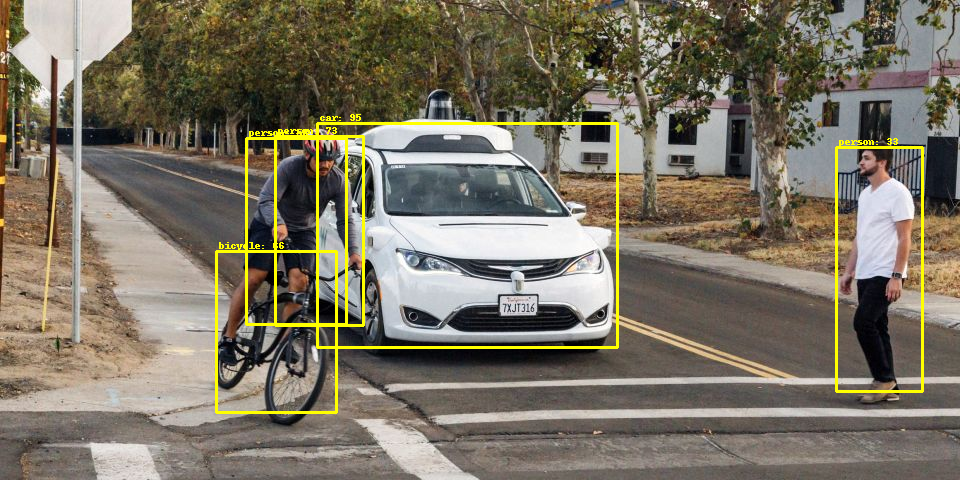

In [15]:
min_conf_threshold = 0.3
draw = ImageDraw.Draw(image)
img_width = image.size[0]
img_height = image.size[1]

for i in range(len(scores)):
    if ((scores[i] > min_conf_threshold) and (scores[i] <= 1.0)):
        y_min = boxes[i][0]
        x_min = boxes[i][1]
        y_max = boxes[i][2]
        x_max = boxes[i][3]
        box = (y_min, x_min, y_max, x_max)
        object_name = labels[int(classes[i])] # Look up object name from "labels" array using class index
        label = f'{object_name}: {int(scores[i]*100)}'# Example: 'person: 72%'
        draw_box(draw, box, img_width, img_height, label)

display(image)


Would like to fix the overlapping people - use IOU to drop box with lowest confidence?